#### Import Libraries

In [1]:
from collections import defaultdict
import pubchempy as pcp
from Bio import Entrez
from tqdm import tqdm
import pandas as pd
import numpy as np
import requests
import re

In [ ]:
def CID_information(CID: int):
    cleaned_cid = int(re.sub(r"CID[m|s]*0*", "", CID))
    compound = pcp.Compound.from_cid(cleaned_cid)
    try:
        compound_name = compound.synonyms[0]
    except:
        compound_name = compound.iupac_name
    return (compound_name, compound.canonical_smiles)

#### Extra code - might use later. This is to retrieve info from the gene db.

In [ ]:
#bAckgr

from Bio import Entrez, Medline

# Set your email address (required for NCBI API usage)
Entrez.email = 'your_email@example.com'

# Define the drug name (e.g., "Aspirin")
drug_name = '"alendronic acid" AND hasabstract'

handle = Entrez.esearch(db='pubmed', term=drug_name, retmax=5)
paper_list = Entrez.read(handle)["IdList"]
handle.close()

handle = Entrez.efetch(db='pubmed', rettype='medline', retmode="text", id=paper_list)
d = Medline.parse(handle)

s = []
for r in d:
    s.append(r)

s[0]

d["PubmedArticle"][1]["MedlineCitation"]["Article"]["Abstract"]["AbstractText"][0]

from bs4 import BeautifulSoup

abstract_text = d["PubmedArticle"][3]["MedlineCitation"]["Article"]["Abstract"]["AbstractText"][0]
soup = BeautifulSoup(abstract_text, 'html.parser')
cleaned_text = soup.get_text()
print(cleaned_text)

In [ ]:
def get_protein_info(record):
    return f"{record[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_locus']} ({record[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_desc']})",\
    record[0]["Entrezgene_summary"],\
    record[0]["Entrezgene_prot"]

cleaned_gene_id = int(re.sub("9606.ENSP0*", "", gene))
Entrez.email = "sample_email@example.org" #Doesn't really matter
handle = Entrez.efetch(db="gene", id=cleaned_gene_id, rettype="gb", retmode="xml")
record = Entrez.read(handle)

try:
    all_information["gene name"], all_information["gene summary"], all_information["proteins from gene"] = get_protein_info(record)
except:
    continue

Entrez.email = "sample_email@example.org" #Doesn't really matter
handle = Entrez.efetch(db="gene", id=7448, rettype="gb", retmode="xml")
record = Entrez.read(handle)

all_information = {}
all_information["gene name"] = f"{record[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_locus']} ({record[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_desc']})"
all_information["gene summary"] = record[0]["Entrezgene_summary"]
all_information["proteins from gene"] = record[0]["Entrezgene_prot"]
all_information

#### DDI sampling

In [ ]:
ddi = pd.read_csv("bio-decagon-combo.csv")

In [ ]:
all_information = defaultdict(list)

for _ in tqdm(range(100)):
    while True:
        sampled_ddi = ddi.sample(n=1)
        drug_1_CID = sampled_ddi["STITCH 1"].to_list()[0]
        drug_2_CID = sampled_ddi["STITCH 2"].to_list()[0]
        relationship = sampled_ddi["Side Effect Name"].to_list()[0]
        
        drug_1_info = CID_information(drug_1_CID)
        drug_2_info = CID_information(drug_2_CID)
    
        # I want the drug name to not include any numbers or brackets, i.e., only keep regular words.
        try:
            if not (re.search(r"[\W\d]", drug_1_info[0]) or re.search(r"[\W\d]", drug_2_info[0])):
                break
        except:
            continue

    all_information["drug_1_CID"].append(drug_1_CID)
    all_information["drug_1_name"].append(drug_1_info[0])
    all_information["drug_1_SMILES"].append(drug_1_info[1])
    all_information["relationship"].append(relationship)
    all_information["drug_2_CID"].append(drug_2_CID)
    all_information["drug_2_name"].append(drug_2_info[0])
    all_information["drug_2_SMILES"].append(drug_2_info[1])
    
    """print(f"Natural Language Triple: {drug_1_info[0]} -- {relationship} -- {drug_2_info[0]}")
    print(f"{drug_1_info[0]} SMILES: {drug_1_info[1]}")
    print(f"{drug_2_info[0]} SMILES: {drug_2_info[1]}")"""

# I might see certain elements appearing more than once. However, they all have different relationships with drug 2.
pd.DataFrame(all_information).to_csv("DDI_subset.csv", index=False)

#### DPI sampling

In [ ]:
ddi_subset = pd.read_csv("DDI_subset.csv")
dpi = pd.read_csv("bio-decagon-targets-all.csv")
actions = pd.read_csv("9606.actions.v5.0.tsv", sep="\t")

all_drugs_CID = set(ddi_subset["drug_1_CID"].to_list() + ddi_subset["drug_2_CID"].to_list())

# The query returns A LOT of DPIs. We need only a subset of them. Thus, randomly sampling from them.
dpi_subset = dpi.query("STITCH in @all_drugs_CID").sample(n=100, random_state=77)

# Converting PubChem CID to STITCH CIDs (singular element) (https://www.biostars.org/p/155342/)
dpi_subset['STITCH'] = dpi_subset['STITCH'].str.replace('CID0', 'CIDs')

In [ ]:
search_list = []
for row in tqdm(dpi_subset.itertuples()):  
    # Retrieving protein data from the given gene ID
    url = f"https://string-db.org/api/json/get_string_ids?identifiers={row.Gene}&species=9606"
    try:
        response = requests.get(url).json()[0]
        string_id = (response["stringId"], response["preferredName"], response["annotation"], row.Gene)
    except:
        continue

    search_list.append((row.STITCH, string_id))

In [ ]:
"""
NOTES/OBSERVATIONS:

1. I decided to do a_is_acting == 't' as otherwise, we would get matches like this which, imo, doesn't really make sense, i.e., 
what does a protein "acting" on a drug mean? - drug acting on a protein makes more sense.

8063 	9606.ENSP00000320025 	CIDs00003333 	inhibition 	inhibition 	f 	991
8064 	CIDs00003333 	9606.ENSP00000320025 	inhibition 	inhibition 	t 	991

2. In theory, actions.query("(item_id_a in @l1) and (item_id_b in @l2)") should return 100 rows for each interaction. However, there are 
certain dpi's like below that have different interaction scores, whether a acts on b, etc. Thus, we filter out those with our conditions.

21666299 	CIDs00060795 	9606.ENSP00000289753 	inhibition 	inhibition 	t 	958
21666301 	CIDs00060795 	9606.ENSP00000289753 	binding 	NaN 	t 	800

3. There are certain pairs like, ('CIDs00002435', '9606.ENSP00000398832') that do not have an entry in the database either as
(item_id_a, item_id_b) or (item_id_b, item_id_a) - This in turn reduces the number of samples.

4. I am bound to see more a_is_acting = f since it is the major element in the actions db by about 30 times more than t.
a_is_acting
f    21078378
t      695113.

5. Even if I consider a->b and b->a relationships, I'm getting certain useless pairs such as the following which doesn't really give me any
additional information.
1448204 	9606.ENSP00000241256 	CIDs00002477 	binding 	NaN 	f 	894
1448205 	CIDs00002477 	9606.ENSP00000241256 	binding 	NaN 	f 	894

6. This will return a lower number than the rows in r since there can be multiple relationships between the same drug-protein pair.
r = actions.query("item_id_a in @l1")
r = r[r.apply(lambda x: (x["item_id_a"], x["item_id_b"]) in target_pairs, axis=1)]
len(set([(x.item_id_a, x.item_id_b) for x in r.itertuples()]))

7. Out of 200 possible (a,b) and (b,a) combinations, 154 exist in the database.
r = actions.query("item_id_a in @l1 or item_id_b in @l1")
len(set(target_pairs).intersection(set([(x.item_id_a, x.item_id_b) for x in r.itertuples()]).union(set([(x.item_id_b, x.item_id_a) for x in r.itertuples()]))))
"""

In [ ]:
target_pairs = list(zip([x[0] for x in search_list], [x[1][0] for x in search_list]))
l1 = [x[0] for x in target_pairs]

In [ ]:
'''
I'm only searching one column (item_id_a) with the CID's. All of my CID's WILL be present in that column, since each CID is mentioned once
in item_id_a and another in item_id_b.
'''
r = actions.query("item_id_a in @l1")
'''
1. I can do the following check since if (a, b) does not exist in the db, (b, a) also wont.
2. I'm not bothered about the "action" since that is directional. (a,b) and (b,a) WILL have the SAME "mode", i.e., relationship.
That's why I'm just doing (a, b).
'''
r = r[r.apply(lambda x: (x["item_id_a"], x["item_id_b"]) in set(target_pairs), axis=1)]

In [ ]:
search_df = pd.DataFrame({"cid": [x[0] for x in search_list],
"protein_number": [x[1][0] for x in search_list],
"protein_name": [x[1][1] for x in search_list], 
"protein_desc": [x[1][2] for x in search_list],
"gene": [x[1][3] for x in search_list]})

In [ ]:
r = pd.merge(r, search_df, left_on=["item_id_a", "item_id_b"], 
             right_on=["cid", "protein_number"], how="inner").drop(columns=["item_id_a", "item_id_b", "action", "a_is_acting", "score"])

r["cid"] = r["cid"].str.replace("CIDs", "CID0") # Going back to PubChem CID to be compatible with other DDI
r.to_csv("DPI_subset.csv", index=False)

#### PPI sampling

In [ ]:
ppi = pd.read_csv("bio-decagon-ppi.csv")
dpi_subset = pd.read_csv("DPI_subset.csv")

In [ ]:
all_genes = set(dpi_subset["gene"].to_list())

In [ ]:
# I use this condition since I don't want to introduce new genes as a part of the dataset.
r = ppi[ppi["Gene 1"].isin(all_genes) & ppi["Gene 2"].isin(all_genes)].sample(n=100, random_state=77)

In [ ]:
'''
nscore - neighborhood score, (computed from the inter-gene nucleotide count).
fscore - fusion score (derived from fused proteins in other species).
pscore - cooccurence score of the phyletic profile (derived from similar absence/presence patterns of genes).
ascore - coexpression score (derived from similar pattern of mRNA expression measured by DNA arrays and similar technologies).
escore - experimental score (derived from experimental data, such as, affinity chromatography).
dscore - database score (derived from curated data of various databases).
tscore - textmining score (derived from the co-occurrence of gene/protein names in abstracts).
'''
all_res = []
for row in tqdm(r.itertuples()):    
    # I'm passing the gene ID directly since STRING maps these ID's automatically to the gene's main protein.
    # species 9606 = human.
    url = f"https://string-db.org/api/json/network?identifiers={'%0d'.join([str(row._1), str(row._2)])}&species=9606"
    try:
        response = requests.get(url).json()
        response[0]["Gene 1"] = row._1
        response[0]["Gene 2"] = row._2
        all_res.append(response[0])
    except:
        continue

In [ ]:
'''
My interpretation of the scores (after reading a bit online):
nscore - How close the 2 genes are in the genome (the entire set of organism DNA)
fscore - Evidence of whether the 2 genes fuse together to form a hybrid gene
pscore - Evidence of whether the 2 genes have a common ancestor (homologous)
ascore - Evidence of whether the 2 genes are simultaneously activated or not.
escore - Evidence of whether the 2 genes have been shown to interact through lab experiments.
dscore - Degree of presence in existing datasbases.
tscore - Evidence of reporting in literature.
'''
def return_edge_label(pair: dict):
    pair_scores = {'nscore': pair['nscore'], 'fscore': pair['fscore'], 'pscore': pair['pscore'], 'ascore': pair['ascore'], 
                   'escore': pair['escore'], 'dscore': pair['dscore'], 'tscore': pair['tscore']}
    best_evidence = max(pair_scores.items(), key=lambda x: x[1])
    if best_evidence[0] == 'nscore':
        return "neighborhood_evidence"
    elif best_evidence[0] == 'fscore':
        return "fusion_evidence"
    elif best_evidence[0] == 'pscore':
        return "homologous_evidence"
    elif best_evidence[0] == 'ascore':
        return "co-expression_evidence"
    elif best_evidence[0] == 'escore':
        return "experimental_evidence"
    elif best_evidence[0] == 'dscore':
        return "database_evidence"
    elif best_evidence[0] == 'tscore':
        return "literature_evidence"

In [ ]:
for idx in range(len(all_res)):
    all_res[idx]["relationship"] = return_edge_label(all_res[idx])

In [ ]:
pd.DataFrame(all_res)[["Gene 1", "Gene 2", "stringId_A", "stringId_B", "preferredName_A", "preferredName_B", 
                       "relationship"]].to_csv("PPI_subset.csv", index=False)

#### Visualizing the network

In [2]:
ddi_subset = pd.read_csv("DDI_subset.csv")
dpi_subset = pd.read_csv("DPI_subset.csv")
ppi_subset = pd.read_csv("PPI_subset.csv")

In [5]:
all_drugs_CID = set(ddi_subset["drug_1_CID"].to_list() + ddi_subset["drug_2_CID"].to_list())
len(all_drugs_CID)

128

In [11]:
len(set(dpi_subset["gene"].to_list()))

58

In [14]:
all_genes = set(ppi_subset["Gene 1"].to_list() + ppi_subset["Gene 2"].to_list())
len(all_genes)

35

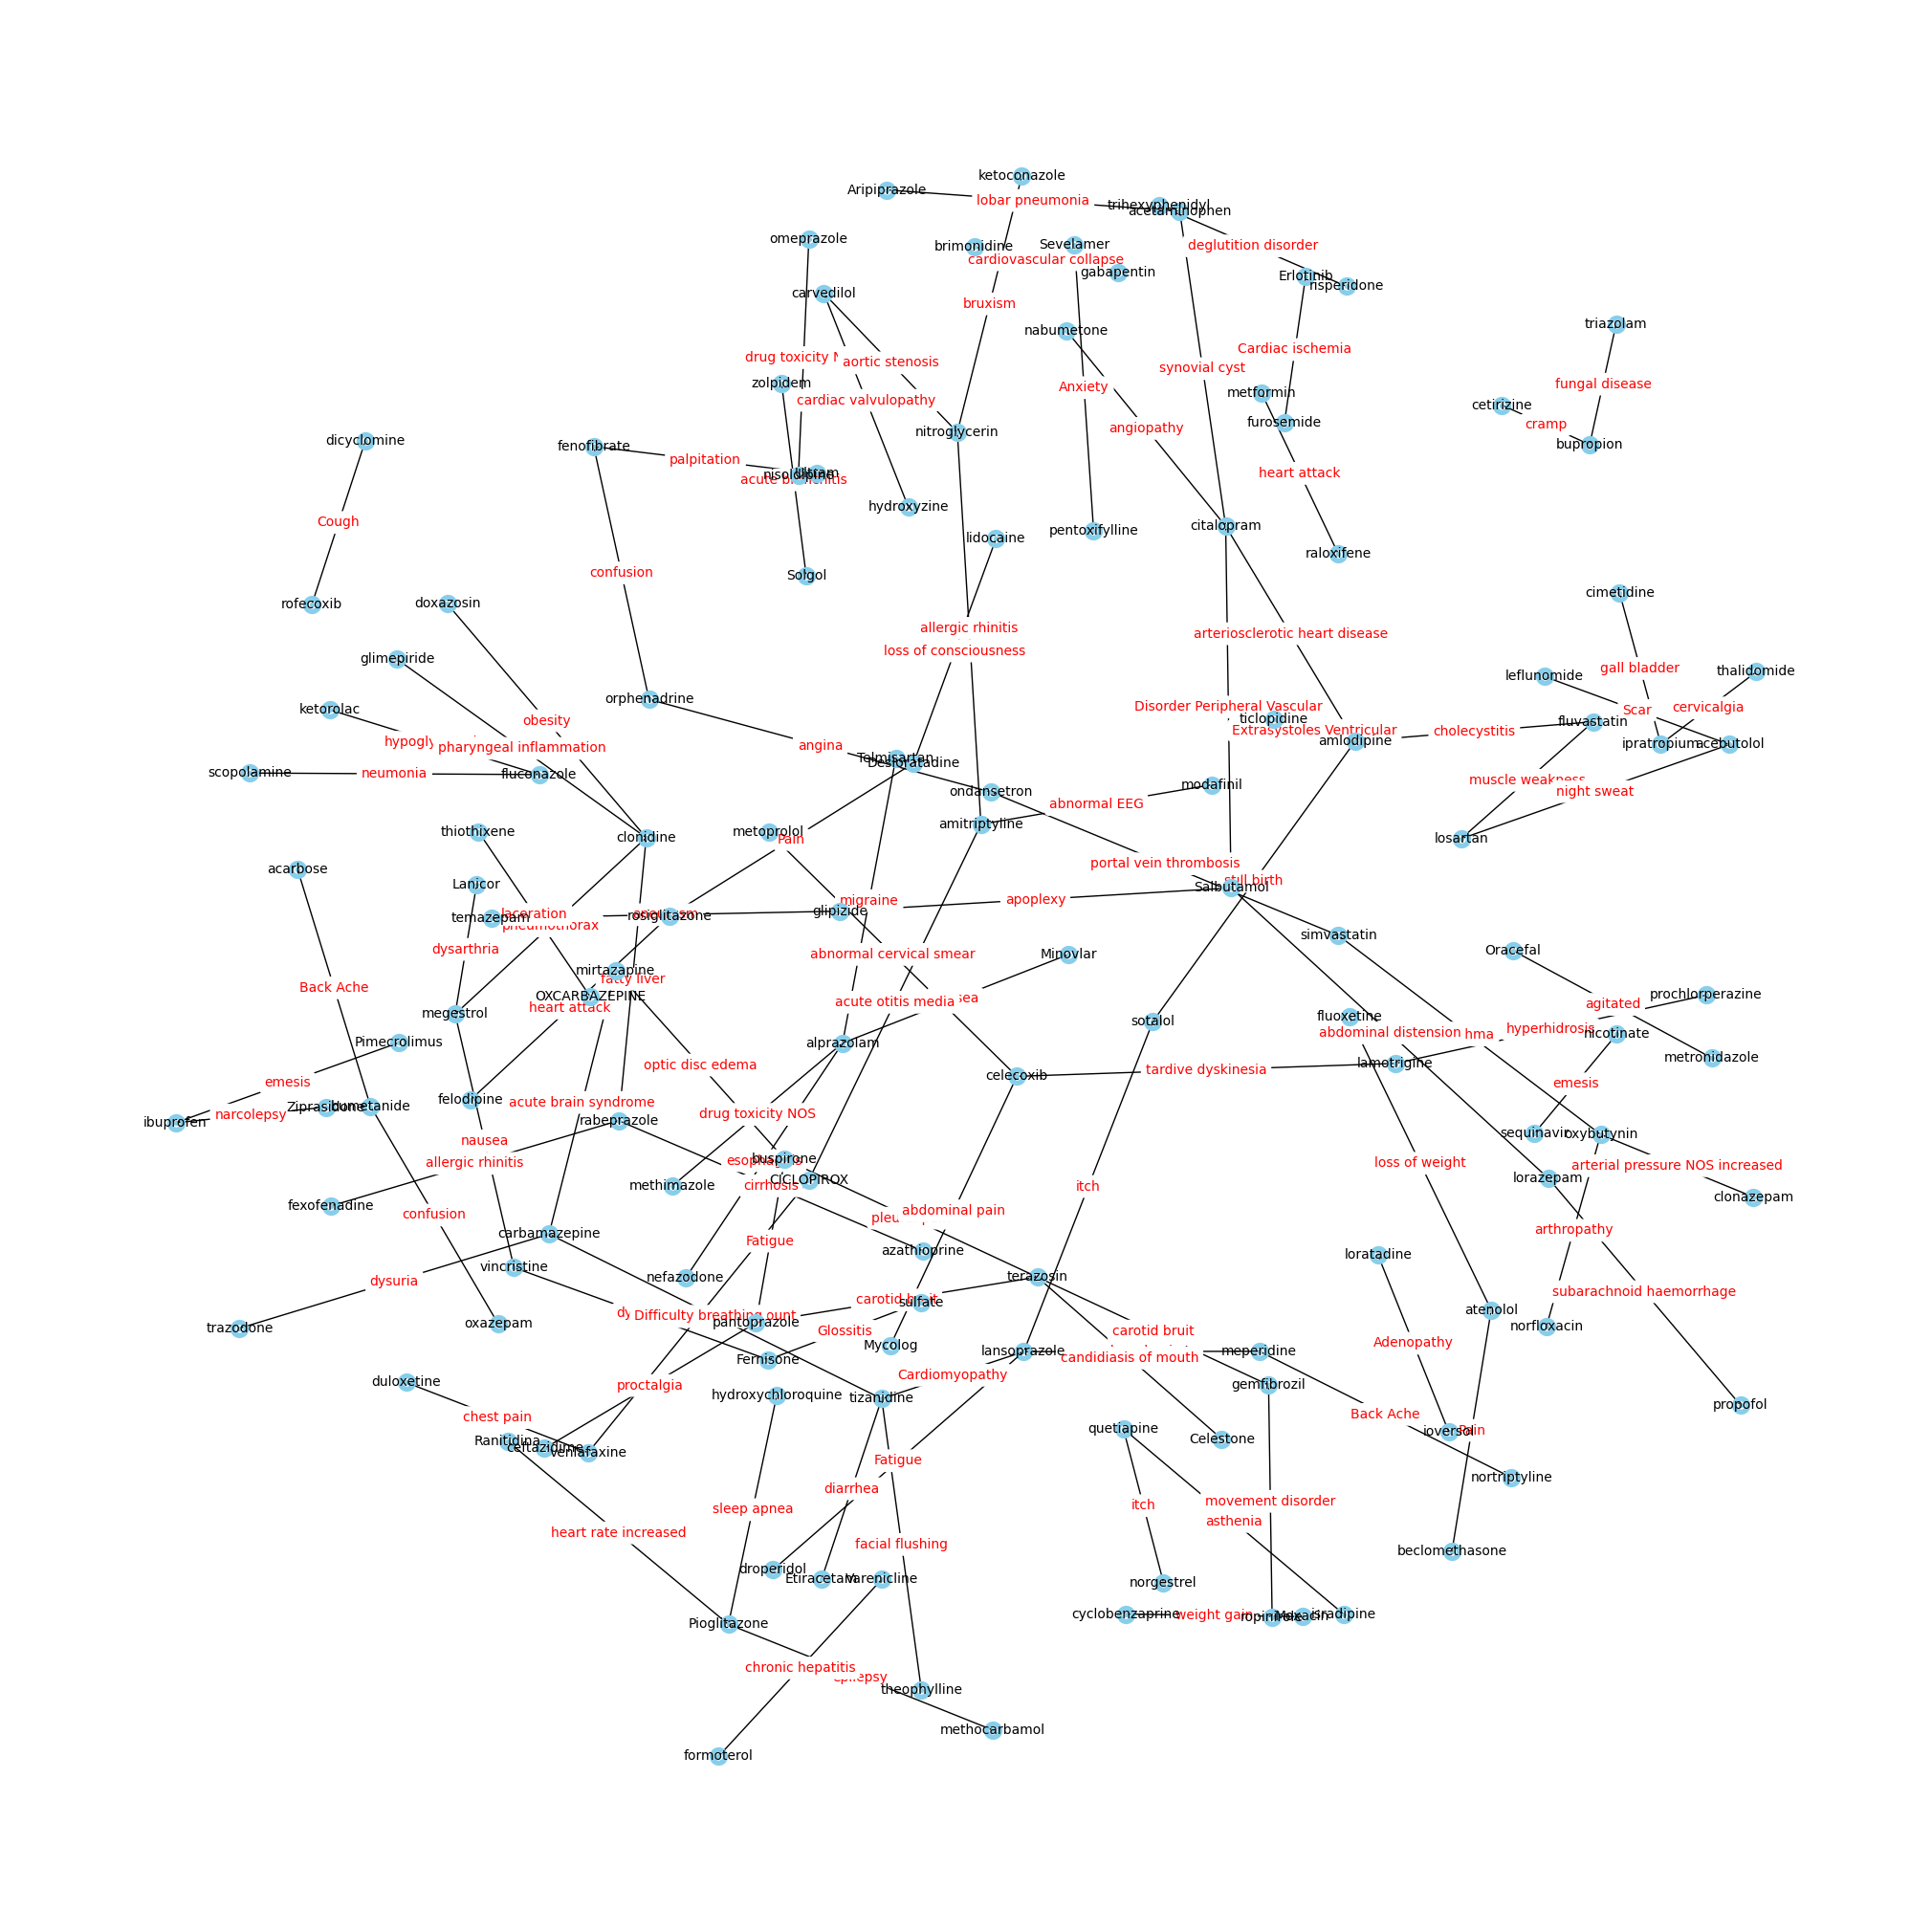

In [79]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add edges to the graph
for index, row in ddi_subset.iterrows():
    G.add_edge(row['drug_1_name'], row['drug_2_name'], label=row['relationship'])

# Draw the graph
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed
pos = nx.spring_layout(G, k=0.15, iterations=15)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=15, edge_color='black', linewidths=10, font_size=10)

# Add edge labels
edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, rotate=False, font_color='red')

plt.show()

In [18]:
ddi_subset.query("drug_2_name == 'sotalol'")

,drug_1_CID,drug_1_name,drug_1_SMILES,relationship,drug_2_CID,drug_2_name,drug_2_SMILES
0,CID000003883,lansoprazole,CC1=C(C=CN=C1CS(=O)C2=NC3=CC=CC=C3N2)OCC(F)(F)F,itch,CID000005253,sotalol,CC(C)NCC(C1=CC=C(C=C1)NS(=O)(=O)C)O
40,CID000002162,amlodipine,CCOC(=O)C1=C(NC(=C(C1C2=CC=CC=C2Cl)C(=O)OC)C)C...,still birth,CID000005253,sotalol,CC(C)NCC(C1=CC=C(C=C1)NS(=O)(=O)C)O
